## B-value calculator and visualizer

by Yair Franco

##### Obspy, Cartopy, and FFmpeg must be installed. Some files (provided on project folder) are also needed.

##### Earthquake catalogs obtained from Northern California Seismic Network double-difference catalog: https://www.ncedc.org/ncedc/catalog-search.html

Earthquake catalogs in project folder:

napa1984_present.txt: Catalog of Napa area, 1984-2022

calaveras2010_present.txt: Catalog of southern Calaveras Fault, near Alum rock, 2010-2022

bayarea84_present.txt: Catalog of full San Francisco Bay area, extending to Monterey Bay and part of the Central Valley, 1984-2022

In [1]:
#!conda install -c conda-forge obspy
#!conda install -c conda-forge cartopy

### Map and b-value function code provided by Yifang Cheng, Ph.D

In [2]:
import warnings
warnings.filterwarnings('ignore') # ignore warnings
import numpy as np
import matplotlib as mpl
from matplotlib.pyplot import *
%matplotlib inline 
# plot inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png') # output map figure in png format
import matplotlib.pyplot as plt
from obspy.core.utcdatetime import UTCDateTime #convert time to UTC time
mpl.rcParams['figure.dpi']= 500 # setup map figure resolution

In [3]:
qfault=np.loadtxt('qfaults.txt') # fault data from USGS website

In [4]:
year = []
lat = []
lon = []
dep = []
mag = []
evid = []
time_utc = []
time_year = []
fid = open('bayarea84_present.txt') #input your earthquake catalog file here
# read in the header
line = fid.readline()
print(line)
line = fid.readline()
print(line)

#read in event lines
num = 0
for line in fid:
    num = num + 1
    if num%1000 == 0:
        print(num)
    info = line.split()
    if len(info) <2:
        continue
    iyear = int(info[0][:4])
    ilat = float(info[2])
    ilon = float(info[3])
    idep = float(info[4])
    imag = float(info[5])
    ievid = int(info[-1])
    itime_utc = float(UTCDateTime(info[0]+'T'+info[1]))
    itime_year = iyear + (itime_utc-float(UTCDateTime(iyear,1,1)))/(float(UTCDateTime(iyear+1,1,1)-float(UTCDateTime(iyear,1,1))))

    year.append(iyear)
    lat.append(ilat)
    lon.append(ilon)
    dep.append(idep)
    mag.append(imag)
    evid.append(ievid)
    time_utc.append(itime_utc)
    time_year.append(itime_year)
  
#convert list into array
year = np.asarray(year)
lat = np.asarray(lat)
lon = np.asarray(lon)
dep = np.asarray(dep)
mag = np.asarray(mag)
evid = np.asarray(evid)
time_utc = np.asarray(time_utc)
time_year = np.asarray(time_year)

Date       Time              Lat        Lon   Depth   Mag Magt  Nst Gap  Clo  RMS  SRC   Event ID

-------------------------------------------------------------------------------------------------

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000
88000
89000
90000
91000
92000
93000
94000
95000
96000
97000
98000
99000
100000
101000
102000
103000
104000
105000
106000
107000


In [5]:
def convert(lat_all,lon_all,lat0,lon0,azimuth,mdist,halfwidth=10):
    # Input:
    # lat_all: latitude of all points
    # lon_all: longitude of all points
    # lat0, lon0 : starting point location for the projection
    # azimuth: azimuth of the projection
    # mdist: distance along the projection from lat0,lon0
    # halfwidth: half width from the projection line
    
    # Output:
    # dist_along_all, dist_norm_all: distance along and normal to the projection
    # mlat, mlon: end point of the projection
    # box_coor: coordinates of the selected polygon
    import math
    x_all = (lon_all-lon0)*40000*np.cos((lat_all+lat0)*np.pi/360)/360
    y_all = (lat_all-lat0)*40000/360
    
    x0=0
    y0=0
    x1=np.sin(azimuth/180*np.pi)
    y1=np.cos(azimuth/180*np.pi)
    
    dist_all=np.sqrt(x_all**2+y_all**2)
    
    dist_along_all=x_all*x1+y_all*y1
    dist_norm_all=x_all*y1-y_all*x1
    
    mlat=mdist*y1*360/40000+lat0
    mlon=mdist*x1*360/40000/np.cos((mlat+lat0)*np.pi/360)+lon0
    
    blat1=lat0+halfwidth*x1*360/40000
    blon1=lon0-halfwidth*y1*360/40000/np.cos((mlat+lat0)*np.pi/360)
    blat2=lat0-halfwidth*x1*360/40000
    blon2=lon0+halfwidth*y1*360/40000/np.cos((mlat+lat0)*np.pi/360)
    blat3=mlat-halfwidth*x1*360/40000
    blon3=mlon+halfwidth*y1*360/40000/np.cos((mlat+lat0)*np.pi/360)
    blat4=mlat+halfwidth*x1*360/40000
    blon4=mlon-halfwidth*y1*360/40000/np.cos((mlat+lat0)*np.pi/360)
    
    
    box_coor=np.asarray([[blat1,blon1],[blat2,blon2],[blat3,blon3],[blat4,blon4],[blat1,blon1]])
    return dist_along_all,dist_norm_all,mlat,mlon,box_coor

#### This polygon will select a certain area of the catalog to analyze. It appears as blue lines on the map below.

You can change the coordinates, azimuth, and length of the polygon to investigate an area of your choice, too.

In [6]:
lat0_proj= 38.4
lon0_proj=-122.4
azimuth_proj=160
mdist_proj=50
dist_along_proj,dist_norm_proj,mlat_proj,mlon_proj,box_coor_proj= \
    convert(lat,lon,lat0_proj,lon0_proj,azimuth_proj,mdist_proj,halfwidth=5)

#### This map visualizes the earthquake data by mapping earthquakes and marking them depending on magnitude and depth. 

The limits of the map here represent the limits of the catalog selection in bayarea84_present.txt (if the map were zoomed out, you'd see the corners where earthquakes are no longer being mapped). 

This map and the polygon where certain earthquakes are selected are referenced multiple times below. The final animation is a representation of this map, though no geopraphic features and references are mapped due to limitations.

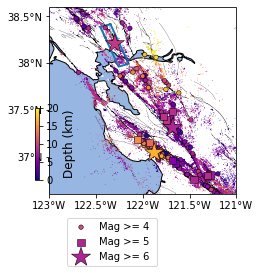

In [7]:
%matplotlib inline
import cartopy.feature as cfeature
import cartopy.crs as ccrs
from mpl_toolkits.axes_grid1 import make_axes_locatable
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

lake_10m = cfeature.NaturalEarthFeature('physical', 'lakes', '10m',
                                        edgecolor='k',
                                         linewidth=0.5,
                                        facecolor=cfeature.COLORS['water'])

provinces_10m = cfeature.NaturalEarthFeature('cultural',
                                             'admin_1_states_provinces_lines',
                                             '10m',
                                             facecolor='none')
oceans_10m = cfeature.NaturalEarthFeature('physical',
                                             'ocean',
                                             '10m',
                                             facecolor=cfeature.COLORS['water'])

fig=plt.figure()
ax = fig.add_axes([0, 0, 1, 0.65], projection=ccrs.PlateCarree())

ax.add_feature(lake_10m)
ax.add_feature(oceans_10m)
ax.add_feature(provinces_10m)
ax.add_feature(cfeature.BORDERS)
ax.coastlines('10m')

#index = np.where(mag>=3)
#ax.scatter(lon[index],lat[index],marker='*',s=50,lw=0.5,cmap='plasma',edgecolors='k',c=dep[index],zorder=5, \
#              vmin=0,vmax=20,label='Mag >= 3')
index = np.where(mag>=4)
ax.scatter(lon[index],lat[index],marker='o',s=20,lw=0.5,cmap='plasma',edgecolors='k',c=dep[index],zorder=5, \
              vmin=0,vmax=20,label='Mag >= 4 ')
index = np.where(mag>=5)
ax.scatter(lon[index],lat[index],marker='s',s=50,lw=0.5,cmap='plasma',edgecolors='k',c=dep[index],zorder=5, \
              vmin=0,vmax=20,label='Mag >= 5 ')
index = np.where(mag>=6)
ax.scatter(lon[index],lat[index],marker='*',s=400,lw=0.5,cmap='plasma',edgecolors='k',c=dep[index],zorder=5, \
              vmin=0,vmax=20,label='Mag >= 6 ')
im = ax.scatter(lon,lat,c=dep,s=0.4,edgecolors='none',cmap='plasma', \
               vmin=0,vmax=20)
ax.legend(bbox_to_anchor=(0.6,-0.1))

ax.set_yticks(np.arange(36,39+0.1,0.5))
ax.set_xticks(np.arange(-123,-121+0.1,0.5))
ax.plot(qfault[:,1],qfault[:,0],lw=0.2,c='k',zorder=3)


ax.plot(box_coor_proj[:,1],box_coor_proj[:,0],lw=2)
lon_formatter = LongitudeFormatter(number_format='g',dateline_direction_label=True)
lat_formatter = LatitudeFormatter(number_format='g')
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)
ax.set_ylim(36.6,38.6)
ax.set_xlim(-123,-121)

cax1 = fig.add_axes([0.25, 0.05, 0.01, 0.25])
cbar=fig.colorbar(im,cax=cax1,fraction=0.04, pad=0.03,
                  label='Depth (km)',ticks=[0,5,10,15,20])
cbar.set_label(label='Depth (km)',fontsize=12)

#### This is a closer analysis of the polygon selection, plotting depth and time against length along the polygon face.

Large earthquakes (where magnitude is larger than the variable 'thresh') are marked by stars.

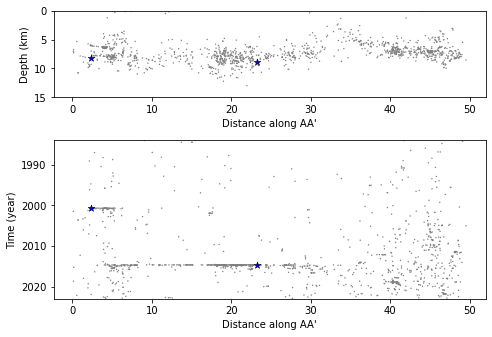

In [8]:
thresh = 4
fig = plt.figure()
ax = fig.add_axes([0, 0.7, 1, 0.3])
index = np.where((dist_along_proj<mdist_proj)&(dist_along_proj>0)&(dist_norm_proj<5)&(dist_norm_proj>-5))[0]
ax.scatter(dist_along_proj[index],dep[index],c='gray',s=2,edgecolors='none')
index_M = np.where((dist_along_proj<mdist_proj)&(dist_along_proj>0)&
                   (dist_norm_proj<5)&(dist_norm_proj>-5)&(mag>=thresh))[0]
ax.scatter(dist_along_proj[index_M],dep[index_M],c='b',s=50,edgecolors='k',lw=0.5,marker='*')
ax.set_ylim(15,0)
ax.set_xlabel("Distance along AA'")
ax.set_ylabel("Depth (km)")

ax = fig.add_axes([0, 0, 1, 0.55])
index = np.where((dist_along_proj<mdist_proj)&(dist_along_proj>0)&(dist_norm_proj<5)&(dist_norm_proj>-5))[0]
ax.scatter(dist_along_proj[index],time_year[index],c='gray',s=2,edgecolors='none')
index_M = np.where((dist_along_proj<mdist_proj)&(dist_along_proj>0)&
                   (dist_norm_proj<5)&(dist_norm_proj>-5)&(mag>=thresh))[0]
ax.scatter(dist_along_proj[index_M],time_year[index_M],c='b',s=50,edgecolors='k',lw=0.5,marker='*')
ax.set_ylim(2023,1984)
ax.set_xlabel("Distance along AA'")
ax.set_ylabel("Time (year)")

plt.show()

#### This function returns b, a, and M<sub>c</sub> using the Gutenber-Richter Law:

$$log_{10}N = a-bM$$

N: Number of earthquakes with magnitude M<sub>w</sub> >= M

M: Magnitude

M<sub>c</sub>: Magnitude of completeness; the magnitude floor defined by the mode of magnitude data.

a: log<sub>10</sub> of total number of events (10<sup>a</sup> = N<sub>total</sub>)

b: the proportion of small to large events. A high b-value represents a higher proportion of smaller events. It is usually close to 1 in seismically active areas, but tends to vary over time. It serves as a statistical indicator of crustal stress.

The purpose of this calculator is to track these variations in b-value and ultimately contextualize them with the occurrence of large earthquakes.

In [9]:
def calc_Mc_b(mag,plot=0):
    nNumberMagnitude=np.floor(mag.max()*10)+1
    xx=np.linspace(np.floor(mag.min()*10)/10,mag.max(),int((np.floor(mag.max()*10)/10-
                                                            np.floor(mag.min()*10)/10)*10)+1)
    vhist,vMagBins=np.histogram(mag,bins=xx)
    iMc = np.where(vhist==vhist.max())[0][-1]
    fMc=vMagBins[iMc]
    hist = vhist[iMc:][::-1]
    bins = vMagBins[iMc:][::-1]
    cum_hist = hist.cumsum()
    log_cum_sum = np.log10(cum_hist)
    bins = bins[1:]
    b,a = np.polyfit(bins, log_cum_sum, 1)
    if plot==1:
        plt.figure()
        plt.subplot(211)
        plt.bar(vMagBins[:-1]+0.05,vhist,0.1)
        plt.axvline(x=fMc,c='r',lw=2)
        plt.title('Mc:'+ "{:.2f}".format(fMc)+'  '+'b value:'+  "{:.2f}".format(-b))
        plt.xlim(-1,8)
        plt.ylabel('# of events')
        plt.subplot(212)
        plt.plot(bins,np.log10(cum_hist))
        plt.plot(bins,a + b*bins)
        plt.xlim(-1,8)
        plt.xlabel('Magnitude')
        plt.ylabel('log10(frequency)')
        plt.show()
        
    return fMc, a, -b

##### Here, b is the negative of the slope of the orange line.

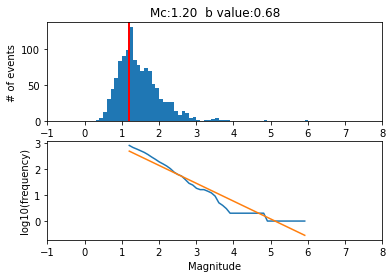

(1.203157894736842, 3.5017303500384847, 0.68380914039813345)

In [10]:
%matplotlib inline
index = np.where((dist_along_proj<mdist_proj)&(dist_along_proj>0)&(dist_norm_proj<5)&(dist_norm_proj>-5))[0]
calc_Mc_b(mag[index],1)

## My code starts here

#### This function adds a b-value to a given array and plots the final temporal change graph

In [11]:
def addbVal_slide(arrayName,bval,dates,firstEQ=0,lastEQ=1,plot=0):
    arrayName.append(bval)
    
    if plot==1:
        xrange = len(arrayName)
        x = dates #startyear was what changed
        
        a,b = np.polyfit(x,arrayName,1)
        
        bMed = np.median(arrayName)
        YLBuffer = 0.1 * bMed
        
        plt.title("b-value change along polygon",fontsize=10, fontweight='bold')
            
        plt.axhspan(0,bMed-YLBuffer,0,xrange,color="red",alpha=0.5)
        plt.axhspan(bMed-YLBuffer,bMed+YLBuffer,0,xrange,color="yellow",alpha=0.5)
        plt.axhspan(bMed+YLBuffer,np.max(arrayName)+0.5,0,xrange,color="green",alpha=0.5)
        
        plt.axhline(y = bMed, color = 'black', linestyle = '--',label=f"Median ({np.around(bMed,3)})")
        plt.plot(x,arrayName,'b.-',label="b-value trend")
        #plt.plot(x,a*x+b,'r',label=f"Best fit line")
        
        #TODO: convert event id to year and mark on x-axis
        
        plt.xlabel(f"Year")
        plt.ylabel('b-value')
        plt.legend()
        plt.ylim(0,np.max(arrayName)+0.5)
        plt.xticks(np.arange(np.around(firstEQ), np.around(lastEQ), step=3))  # Set label locations.
        #plt.xticks([0,1,2],[firstEQ,"middle",lastEQ])
        #plt.rc('xtick', labelsize=3)

#### This loop takes an given index of earthquakes and calculates the b-value using the calculator function and graphs it using the add b-value function. 

In this case, we are taking all earthquakes within the polygon in the map above, which roughly represents the West Napa Fault, where the [2014 Napa earthquake](https://earthquake.usgs.gov/earthquakes/eventpage/nc72282711/executive) occurred. This allows tracking the b-value change on a single fault, or a particular area of interest.

Note the dips in b-value coinciding with the occurrence of large earthquakes. This phenomenon has piqued the interests of seismologists; it has been observed in events such as the [2004 Sumatra earthquake](http://www.diva-portal.org/smash/get/diva2:168371/FULLTEXT01) and the [2019 Ridgecrest earthquakes](https://doi.org/10.1038/s41467-020-16867-5)

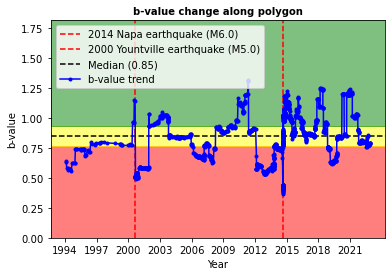

In [12]:
%matplotlib inline

Napa_seg = []
windowSize = 100 #earthquakes used per b-value calculation (the higher, the more accurate, but reduces time resultion)
windows = num-windowSize
timeEnd = 2023 #can also be a decimal of a year
timeStart = 1984

#default area parameters of polygon
areaParams = (dist_along_proj<70)&(dist_along_proj>0)&(dist_norm_proj<5)&(dist_norm_proj>-5)
timeParams = (time_year>timeStart)
index = np.where(areaParams&timeParams) #index[0] gives only event IDs
#print("selected EQs;",index,". # of EQs:",len(index))

dates = [] #saving dates separately to define x-axis of the graph

#plotting some large nearby earthquakes manually to visualize b-value change with respect to their occurence
plt.axvline(x = 2014.6542, color='red', linestyle='--', label='2014 Napa earthquake (M6.0)')
plt.axvline(x = 2000.6735, color='red', linestyle='--', label='2000 Yountville earthquake (M5.0)')

for i in range(windows):
    currentWindow = index[0][i:i+windowSize]
    bvalDate = np.max(time_year[currentWindow])
    dates.append(bvalDate)
    #print("b value date:",bvalDate)
    #print("window 1 full, calculating b-value...",currentWindow)
    bvalSet = (calc_Mc_b(mag[currentWindow]))[2]
    #print(bvalSet)
    if i>=windows-1 or len(currentWindow)<windowSize:
        timeStart = np.min(dates)
        timeEnd = np.max(dates)
        addbVal_slide(Napa_seg,bvalSet,dates,timeStart,timeEnd,1)
        #print(f"calculations finished...plotting")
        break
    else: 
        addbVal_slide(Napa_seg,bvalSet,dates)
        #print(f"b-value stored")
        continue

### We can also plot b-value change in a coordinate system over time. 

#### This approach plots b-value on a grid whose dimensions are directly proportional to the coordinates on the map above. All earthquakes are assigned a space on the gird depending on their location, and then b-value is calculated at each grid space once there are enough earthquakes in it. The b-value is calculated again after each new earthquake.

This does mean that there is a gap between the start of calculations and the b-values actually being mapped. It also means areas with less earthquakes may not have b-value calculations, and if they do, they are not updated as often. However, this approach is very useful for visualizing the extent of spaciotemporal change in b-value during large earthquake sequences.

I recommend running this code and watching the video output (runtime is ~10 minutes, there are lots or numbers involved!) and watching what the b-values do in the map before and after major earthquakes (represented as big stars in the map above). 1989, 2009, 2014, and 2022 are some key years, though you can look for other earthquakes of interest on the [USGS catalog](https://earthquake.usgs.gov/earthquakes/search/) and make your own observations.

In [46]:
%matplotlib qt
from matplotlib import cm
plt.rcParams['animation.ffmpeg_path']=r'C:\Program Files\FFmpeg\bin\ffmpeg.exe'
from matplotlib.animation import FFMpegWriter
metadata = dict(title='Energy/b-value animation', artist='Matplotlib',comment='Made by Yair Franco')
writer = FFMpegWriter(fps=10, metadata=metadata,bitrate=200000)

bfig = plt.figure(figsize=(10,12),dpi=100)

In [47]:
import time
start_time = time.time()

windowSize = 75 #earthquakes used per b-value calculation
frameWindow = 250 #earthquakes mapped per video frame
gridRes = 5 #resolution factor of the grid (the larger, the less data per square, less b-values can be taken)
gridSize = 2 #grid size in degrees. Can be adjusted to select areas in a certain selection

#coordinates of grid origin
orLong = -123 
orLat = 36.6

"""
    x of this catalog collection:
    longs:-123,-121; spans 2 degrees
    lats:  36.6,38.6; spans 2 degrees
"""
gridy = int(gridSize*gridRes) + 1 # + 1 prevents indexing errors
gridx = int(gridSize*gridRes) + 1 #x = lon, y = lat (axes are swapped by numpy in matrix)

eqgrid = np.zeros((gridy,gridx))
bset = np.zeros((gridy,gridx))

#initialize and "grid" dictionary to store magnitudes (indexed with strings, not int)
magdict = {
    
}

for y in range(gridy):
    for x in range(gridx):
        m_coord = f"{y} {x}"
        magdict[m_coord] = []       
#print("this is your dictionary:",magdict)



with writer.saving(bfig, "please be my last videoh.mp4", dpi=100):

        for i in range(num):
            #print("eq",[i],lon[i],lat[i])
            m = mag[i]

            #simplifying coordinates to an origin to make graphing easier
            gridlon = lon[i] - orLong
            gridlat = lat[i] - orLat
            #print(gridlon,gridlat, "gridded...", int(gridRes*gridlon),int(gridRes*gridlat))
            coordx = int(gridRes*gridlon)
            coordy = int(gridRes*gridlat)

            #E = 10**(5.24 * 1.44*m)
            logE = (5.24 * 1.44*m)
            eqgrid[coordy][coordx] += logE #add energy to matrix

            m_coord = f"{coordy} {coordx}" #str(coordy) + ' ' + str(coordx) also works
            magdict[m_coord].append(m) #add magnitude to array on matrix
            #print(m_coord,magdict[m_coord],m)

            for j in range(gridy):
                for k in range(gridx):
                    if len(magdict[f"{j} {k}"]) >= windowSize:
                        #calculate b-value using most recent 50 earthquakes in this grid space
                        bset[j][k] = calc_Mc_b(np.asarray(magdict[f"{j} {k}"][-windowSize:]))[2] 
            
            if i>0 and i%frameWindow == 0:
                bfull = calc_Mc_b(mag[0:i])[2]
                dfull = bfull - bset

                bfig.clear()
                bfig.suptitle(f'Bay Area; year, event #: {year[i],i}',fontsize=12, fontweight='bold')
                ax1 = bfig.add_subplot(222)
                img1 = ax1.imshow(eqgrid,vmin=0,vmax=50000,cmap='hot',interpolation='gaussian',origin='lower')
                plt.colorbar(img1)
                ax1.set_title("cumulative log(E) heat map")
                
                ax2 = bfig.add_subplot(223)
                img2 = ax2.imshow(bset,vmin=0.4,vmax=1.0,cmap='PiYG',interpolation='gaussian',origin='lower')
                plt.colorbar(img2)
                ax2.set_title("b-value heat map")
                
                ax3 = bfig.add_subplot(224)
                img3 = ax3.imshow(dfull,vmin=-0.5,vmax=0.5,cmap='bone',interpolation='gaussian',origin='lower')
                plt.colorbar(img3)
                ax3.set_title(f"difference from b of full area ({np.around(bfull,3)})")
                
                ax4 = bfig.add_subplot(221)
                img4 = ax4.scatter(lon[0:i],lat[0:i],c=dep[0:i],s=4**(mag[0:i]),\
                                   edgecolors='none',cmap='Blues',vmin=0,vmax=20)
                ax4.set_yticks(np.arange(36.6,38.6+0.1,0.5))
                ax4.set_xticks(np.arange(-123,-121+0.1,0.5))
                ax4.set_ylim(36.6,38.6)
                ax4.set_xlim(-123,-121)
                ax4.set_title(f"Earthquakes; largest since previous frame: {np.max(mag[i-frameWindow:i])}")
                
                plt.draw()
                plt.pause(0.01)
                print(f"Saving frame to video: earthquake {i}")
                writer.grab_frame()

print("runtime: %s seconds " % (time.time() - start_time))

Saving frame to video: earthquake 250
Saving frame to video: earthquake 500
Saving frame to video: earthquake 750
Saving frame to video: earthquake 1000
Saving frame to video: earthquake 1250
Saving frame to video: earthquake 1500
Saving frame to video: earthquake 1750
Saving frame to video: earthquake 2000
Saving frame to video: earthquake 2250
Saving frame to video: earthquake 2500
Saving frame to video: earthquake 2750
Saving frame to video: earthquake 3000
Saving frame to video: earthquake 3250
Saving frame to video: earthquake 3500
Saving frame to video: earthquake 3750
Saving frame to video: earthquake 4000
Saving frame to video: earthquake 4250
Saving frame to video: earthquake 4500
Saving frame to video: earthquake 4750
Saving frame to video: earthquake 5000
Saving frame to video: earthquake 5250
Saving frame to video: earthquake 5500
Saving frame to video: earthquake 5750
Saving frame to video: earthquake 6000
Saving frame to video: earthquake 6250
Saving frame to video: earth

Saving frame to video: earthquake 51750
Saving frame to video: earthquake 52000
Saving frame to video: earthquake 52250
Saving frame to video: earthquake 52500
Saving frame to video: earthquake 52750
Saving frame to video: earthquake 53000
Saving frame to video: earthquake 53250
Saving frame to video: earthquake 53500
Saving frame to video: earthquake 53750
Saving frame to video: earthquake 54000
Saving frame to video: earthquake 54250
Saving frame to video: earthquake 54500
Saving frame to video: earthquake 54750
Saving frame to video: earthquake 55000
Saving frame to video: earthquake 55250
Saving frame to video: earthquake 55500
Saving frame to video: earthquake 55750
Saving frame to video: earthquake 56000
Saving frame to video: earthquake 56250
Saving frame to video: earthquake 56500
Saving frame to video: earthquake 56750
Saving frame to video: earthquake 57000
Saving frame to video: earthquake 57250
Saving frame to video: earthquake 57500
Saving frame to video: earthquake 57750


Saving frame to video: earthquake 103000
Saving frame to video: earthquake 103250
Saving frame to video: earthquake 103500
Saving frame to video: earthquake 103750
Saving frame to video: earthquake 104000
Saving frame to video: earthquake 104250
Saving frame to video: earthquake 104500
Saving frame to video: earthquake 104750
Saving frame to video: earthquake 105000
Saving frame to video: earthquake 105250
Saving frame to video: earthquake 105500
Saving frame to video: earthquake 105750
Saving frame to video: earthquake 106000
Saving frame to video: earthquake 106250
Saving frame to video: earthquake 106500
Saving frame to video: earthquake 106750
Saving frame to video: earthquake 107000
Saving frame to video: earthquake 107250
Saving frame to video: earthquake 107500
runtime: 1444.5972912311554 seconds 


Text(0.5, 1.0, 'Earthquakes; largest since previous frame: 3.8')

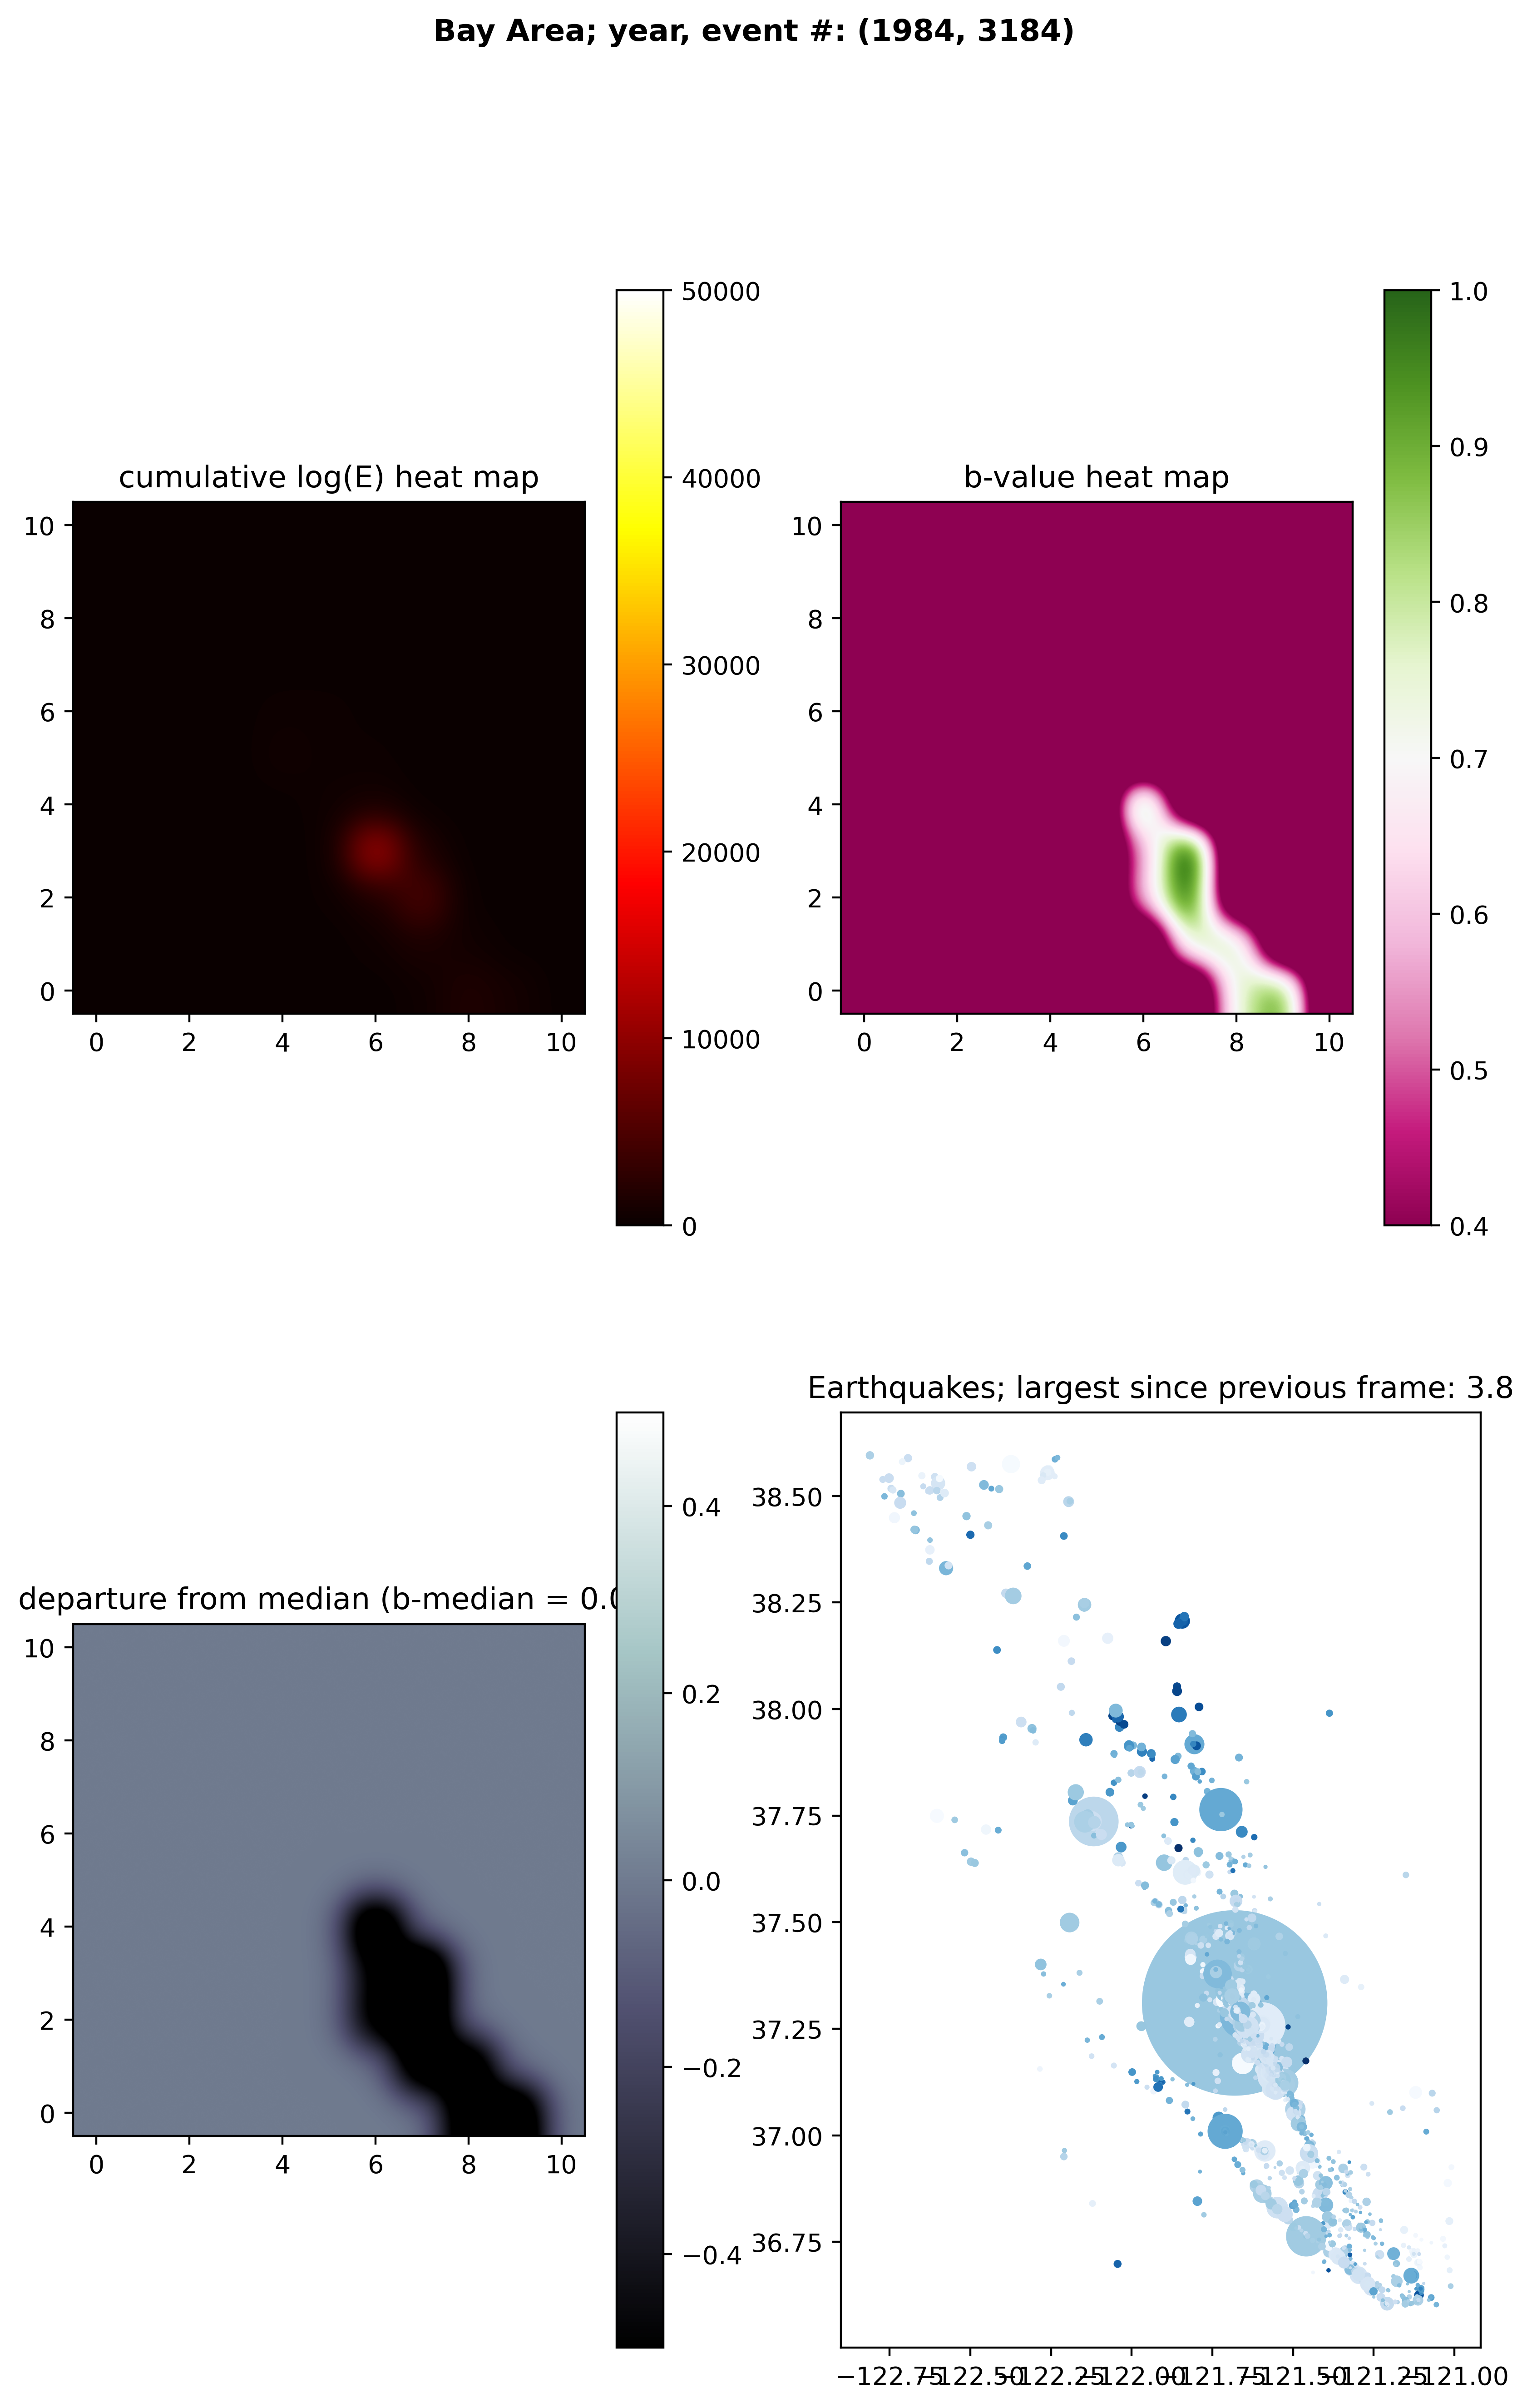

In [20]:
%matplotlib inline

bfig = plt.figure(figsize=(10,15),dpi=400)
bfig.clear()
bfig.suptitle(f'Bay Area; year, event #: {year[i],i}',fontsize=12, fontweight='bold')
ax1 = bfig.add_subplot(221)
img1 = ax1.imshow(eqgrid,vmin=0,vmax=50000,cmap='hot',interpolation='gaussian',origin='lower')
plt.colorbar(img1)
ax1.set_title("cumulative log(E) heat map")

ax2 = bfig.add_subplot(222)
img2 = ax2.imshow(bset,vmin=0.4,vmax=1.0,cmap='PiYG',interpolation='gaussian',origin='lower')
plt.colorbar(img2)
ax2.set_title("b-value heat map")

ax3 = bfig.add_subplot(223)
img3 = ax3.imshow(diffmeds,vmin=-0.5,vmax=0.5,cmap='bone',interpolation='gaussian',origin='lower')
plt.colorbar(img3)
ax3.set_title(f"departure from median (b-median = {mb})")

ax4 = bfig.add_subplot(224)
img4 = ax4.scatter(lon[0:i],lat[0:i],c=dep[0:i],s=4**(mag[0:i]),\
                   edgecolors='none',cmap='Blues',vmin=0,vmax=20)
ax4.set_title(f"Earthquakes; largest since previous frame: {np.max(mag[i-frameWindow:i])}")